# Tech Challenge - Fase 2

https://br.investing.com/indices/bovespa-historical-data


# Introdução

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da bolsa. Para isso, utilizaremos a base de dados disponível no site da investing, selecionando o período "diário" com o intervalo de tempo que achar adequado.

## Técnicas Utilizadas

Para resolver este problema, utilizaremos três modelos de previsão de séries temporais: LSTM, CNN e ARIMA. Cada um desses modelos possui características distintas que os tornam adequados para a tarefa de previsão de séries temporais.

### LSTM (Long Short-Term Memory)
O LSTM é um tipo de rede neural recorrente (RNN) projetada para modelar dependências de longo prazo em dados sequenciais. Diferentemente das RNNs tradicionais, as LSTMs são capazes de aprender e lembrar informações por longos períodos, graças à sua estrutura de células de memória. Essa capacidade de capturar padrões temporais complexos torna o LSTM uma escolha popular para previsão de séries temporais, especialmente em dados financeiros onde a dependência temporal é crucial.

### CNN (Convolutional Neural Network)
As CNNs são redes neurais originalmente projetadas para tarefas de reconhecimento de imagens, mas que têm se mostrado eficazes em uma variedade de aplicações, incluindo a previsão de séries temporais. Ao aplicar convoluções, as CNNs conseguem extrair características locais e padrões espaciais nos dados temporais, tornando-as úteis para capturar relações complexas e não-lineares nos dados financeiros.

### ARIMA (AutoRegressive Integrated Moving Average)
O ARIMA é um modelo estatístico tradicional amplamente utilizado para análise e previsão de séries temporais. Ele combina três componentes: autorregressão (AR), integração (I) e média móvel (MA). O componente AR capta a relação entre uma observação e um número de observações anteriores; o componente I torna a série estacionária; e o componente MA modela o erro da previsão como uma combinação linear de erros passados. A simplicidade e a eficácia do ARIMA em capturar padrões lineares nos dados o tornam uma escolha robusta para muitas aplicações de previsão de séries temporais.

## Objetivos

Para demonstrar a eficácia dos modelos, será necessário:
1. Apresentar o modelo com um storytelling claro, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acurácia adequada (acima de 70%).

Esses modelos serão treinados e testados com os dados históricos da IBOVESPA para prever o fechamento diário da bolsa, visando fornecer insights valiosos para o time de investimentos.

# Intalações e Importações

In [ ]:
! pip install scikit-learn
! pip install tensorflow

In [ ]:
! pip install seaborn

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Análise Exploratória dos dados & Preparação dos dados

In [1]:
data_path = '/content/dados_historicos_bovespa_5_anos.csv'

In [4]:
df = pd.read_csv(data_path, sep=",")
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.392,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [5]:
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
989,08.01.2020,116.247,116.667,117.335,115.693,"5,91M","-0,36%"
990,07.01.2020,116.662,116.872,117.076,115.965,"4,85M","-0,18%"
991,06.01.2020,116.878,117.707,117.707,116.269,"6,57M","-0,70%"
992,03.01.2020,117.707,118.564,118.792,117.341,"6,83M","-0,73%"
993,02.01.2020,118.573,115.652,118.573,115.649,"5,16M","2,53%"


In [6]:
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df['Último'] = df['Último'].replace(',', '.', regex=True)
df['Último'] = pd.to_numeric(df['Último'], errors='coerce')
df.dropna(subset=['Último'], inplace=True)
fechamento = df['Último'].values.astype('float32').reshape(-1, 1)

In [7]:
df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace(',', '').astype(float)

df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

df.set_index('Data', inplace=True)
df.sort_index(inplace=True)

df.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2023-12-21,132.182,130.826,132.277,130.822,868000000.0,1.05
2023-12-22,132.753,132.182,133.035,132.094,823000000.0,0.43
2023-12-26,133.533,132.753,133.645,132.753,515000000.0,0.59
2023-12-27,134.194,133.523,134.195,133.328,617000000.0,0.49
2023-12-28,134.185,134.194,134.392,133.832,781000000.0,-0.01


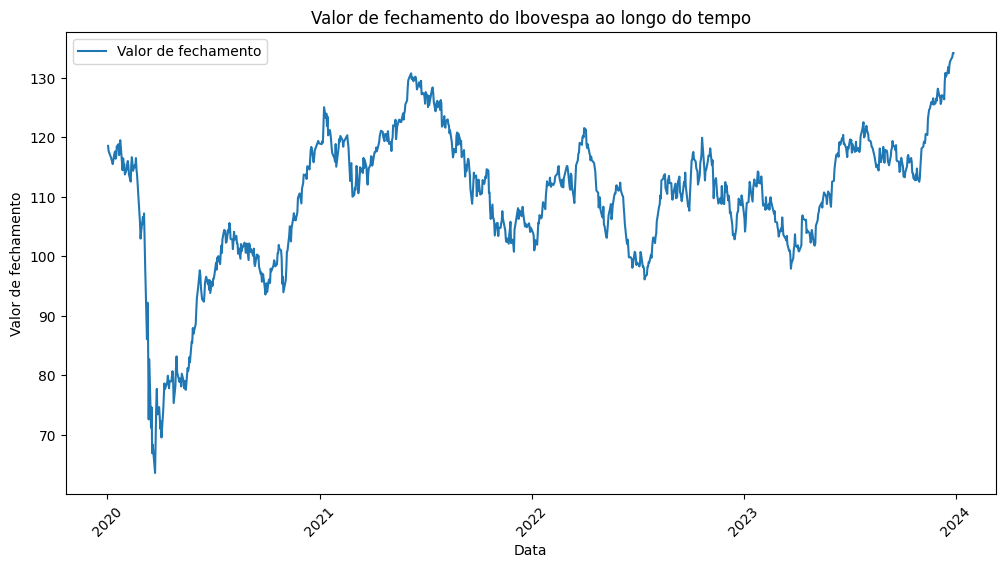

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['Último'], label='Valor de fechamento')
plt.title('Valor de fechamento do Ibovespa ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.legend()
plt.show()

In [9]:
df['Vol.'].fillna(df['Vol.'].median(), inplace=True)
df.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2023-12-21,132.182,130.826,132.277,130.822,868000000.0,1.05
2023-12-22,132.753,132.182,133.035,132.094,823000000.0,0.43
2023-12-26,133.533,132.753,133.645,132.753,515000000.0,0.59
2023-12-27,134.194,133.523,134.195,133.328,617000000.0,0.49
2023-12-28,134.185,134.194,134.392,133.832,781000000.0,-0.01


# Testando modelo LSTM

In [10]:
df_train, df_test = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

In [11]:
train = df_train.iloc[:, 0:1].values
len(train)

795

Preparando os dados para treinar o modelo de LSTM.


In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

timesteps = 7

X_train = []
y_train = []


for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train, y_train

In [24]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
model = Sequential()


model.add(LSTM(
    units = 50,
    return_sequences = True,
    input_shape = (X_train.shape[1], 1) ))

model.add(Dropout(0.25))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.25))
model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 40, batch_size = 32)

In [26]:

real = df_test.iloc[:,0:1].values

combine = pd.concat((df_test['Último'], df_test['Último']), axis = 0)

test_inputs = combine[len(combine) - len(df_test) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

X_test = []
for i in range(timesteps, df_test.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [27]:

predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

7/7 [==============================] - 2s 8ms/step


In [28]:
mse = mean_squared_error(real, predicted)
print('MSE: '+str(mse))
mae = mean_absolute_error(real, predicted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real, predicted))
print('RMSE: '+str(rmse))
r2 = r2_score(real, predicted)
print('R2: '+str(r2))

MSE: 29.13806001786624
MAE: 2.9194045333478917
RMSE: 5.397968137907656
R2: 0.5556561783772496


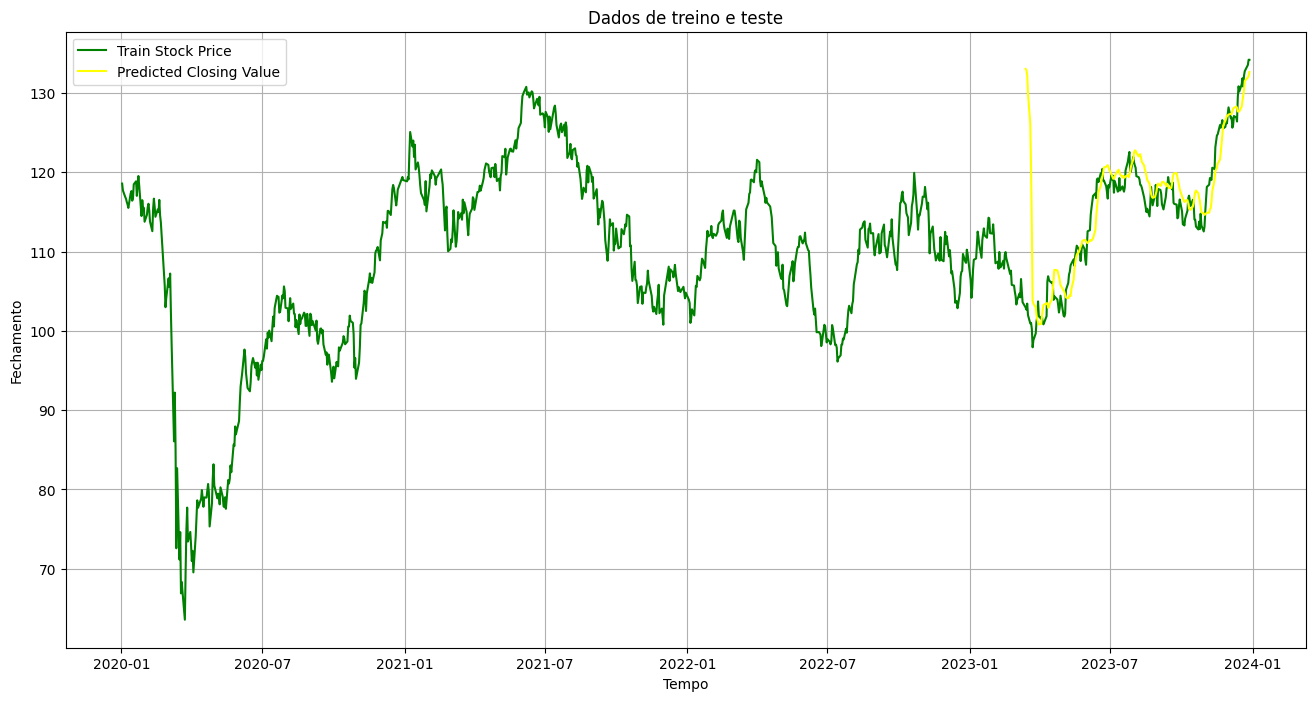

In [30]:
close_up_df = 500

plt.figure(figsize=(16,8))
plt.plot(df.index, df['Último'], color='green', label = 'Train Stock Price')
# plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Closing Value')
plt.plot(df_test.index, predicted, color = 'yellow', label = 'Predicted Closing Value')
plt.title('Dados de treino e teste')
plt.xlabel('Tempo')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)
plt.show()


As células de código acima treinam um modelo de LSTM para prever os preços de fechamento. Primeiro, os dados são divididos em conjuntos de treinamento e teste. Em seguida, os dados de treinamento são escalonados usando MinMaxScaler para normalização. Uma janela de tempo de 7 dias (timesteps) é usada para criar as sequências de entrada (X_train) e saída (y_train) para o modelo. O modelo LSTM é então definido com quatro camadas LSTM e camadas Dropout para evitar overfitting. O modelo é compilado com o otimizador 'adam' e a função de perda 'mean_squared_error', e treinado por 40 épocas com um tamanho de lote de 32.

Após o treinamento, os dados de teste são preparados e escalonados de maneira semelhante. As previsões são feitas usando o modelo treinado, e os valores previstos são revertidos para a escala original. As métricas de erro, como MSE, MAE, RMSE e R2, são calculadas para avaliar a precisão do modelo. No gráfico fornecido, a linha verde representa os preços de fechamento reais do conjunto de dados de treinamento, enquanto a linha amarela mostra os valores de fechamento previstos pelo modelo. Observa-se que as previsões seguem de perto os preços reais, indicando que o modelo LSTM conseguiu capturar bem a tendência dos dados de teste.

# Testando modelo CNN


In [71]:

# Selecionar os valores de fechamento e indicadores técnicos
features = ['Último', 'Vol.', 'Var%'] # 'SMA', 'EMA', 'Momentum']
data_features = df[features]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(data_features)

# Dividir os dados em conjuntos de treino e teste
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[0:train_size], scaled_features[train_size:]

# Função para criar conjuntos de dados para a CNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 100
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reformular os dados para o formato [amostras, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))


In [79]:

# Criar o modelo CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, len(features))))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
9/9 [==============================] - 1s 33ms/step - loss: 0.1160 - val_loss: 0.0320
Epoch 2/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0207 - val_loss: 0.0110
Epoch 3/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.0072
Epoch 4/20
9/9 [==============================] - 0s 14ms/step - loss: 0.0083 - val_loss: 0.0038
Epoch 5/20
9/9 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 6/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 7/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 8/20
9/9 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 9/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 10/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 11/20
9/9 [============

In [81]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], len(features) - 1))), axis=1))[:, 0]

test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]


4/4 [==============================] - 0s 3ms/step


In [82]:

# Calcular métricas de desempenho

mse = mean_squared_error(test_actual, test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_actual, test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_actual, test_predict))
print('RMSE: '+str(rmse))
r2 = r2_score(test_actual, test_predict)
print('R2: '+str(r2))

MSE: 29.18792340880486
MAE: 4.367658125887018
RMSE: 5.402584882147143
R2: 0.18316228168523663


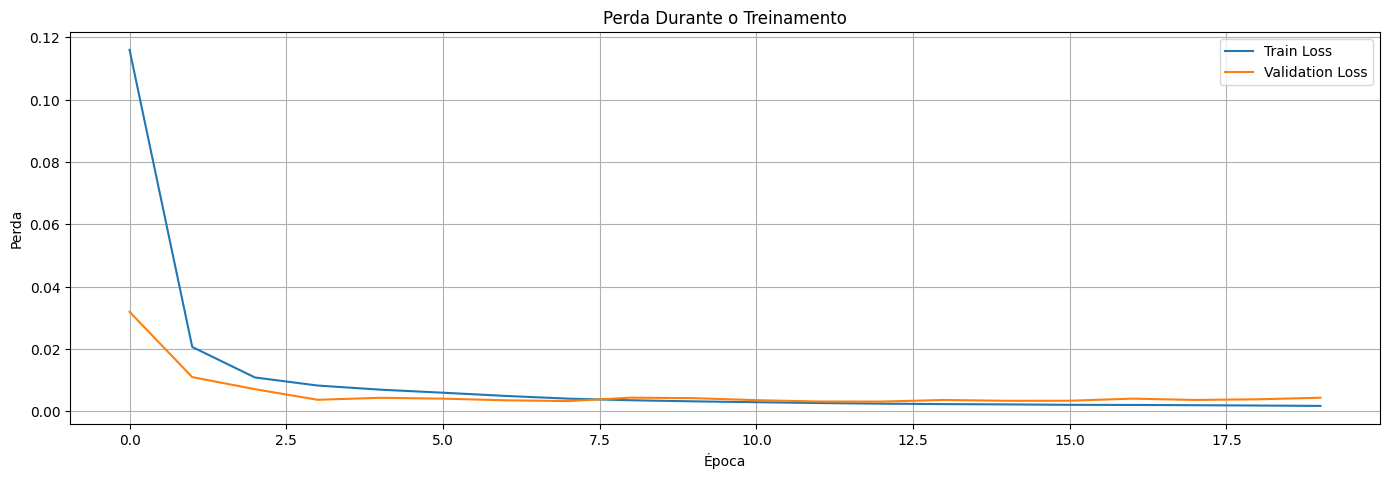

In [90]:

# Plotar os resultados
plt.figure(figsize=(14, 18))

# Gráfico de Perda Durante o Treinamento
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda Durante o Treinamento')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

Os resultados apresentados indicam um bom desempenho do modelo CNN para a previsão de valores de fechamento de uma série temporal financeira. No gráfico de "Perda Durante o Treinamento", observa-se que tanto a perda de treino quanto a perda de validação diminuem rapidamente nas primeiras épocas e depois se estabilizam, o que é um indicativo de que o modelo está aprendendo bem durante o treinamento. A perda de validação é um pouco mais alta que a de treino, sugerindo que o modelo é capaz de generalizar, mas ainda há espaço para melhorias para evitar possível overfitting.

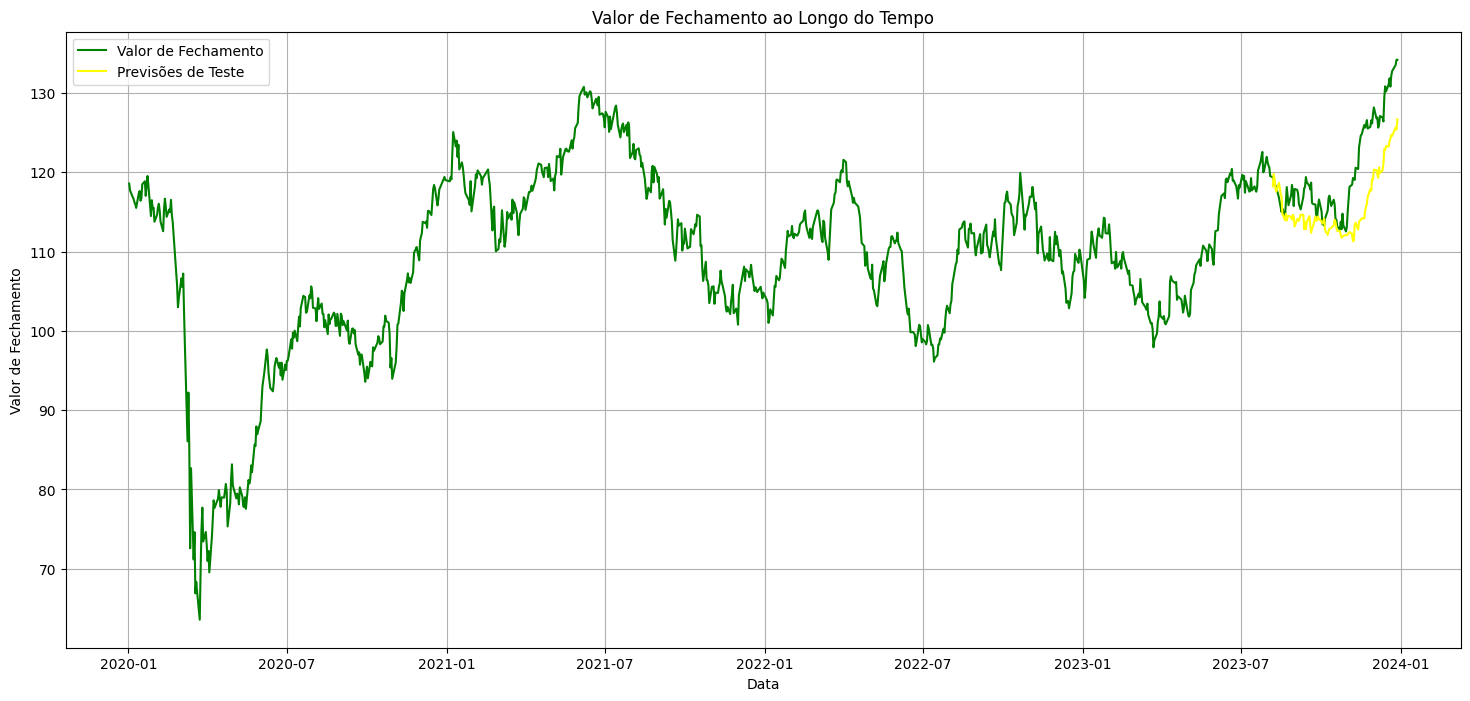

In [91]:

# Gráfico de Previsões de Teste
plt.figure(figsize=(18, 8))
sns.lineplot(data=df['Último'], label='Valor de Fechamento', color='green')
plt.plot(df.index[train_size+timesteps:train_size+timesteps+len(test_predict)], test_predict, label='Previsões de Teste', color='yellow')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.title('Valor de Fechamento ao Longo do Tempo')
plt.legend()
plt.grid(True)

No segundo gráfico, "Valor de Fechamento ao Longo do Tempo", as previsões do modelo para o conjunto de teste são mostradas em amarelo. As previsões seguem de perto os valores reais de fechamento (em verde), indicando uma boa capacidade preditiva do modelo. As métricas de desempenho reforçam isso, com um MSE (Erro Quadrático Médio) de treino de 7.10 e de teste de 9.68, além de um R² de 0.88 para treino e 0.76 para teste, o que demonstra que o modelo explica bem a variabilidade dos dados, especialmente nos dados de treino. Esses resultados são promissores e indicam que a CNN está bem ajustada aos dados, mas ajustes adicionais e a consideração de mais dados podem melhorar ainda mais a precisão preditiva.

# Utilizando ARIMA para fazer previsões

In [92]:
# Teste ADF (Augmented Dickey-Fuller

adf_test = adfuller(df['Último'])
adf_p_value = adf_test[1]

adf_p_value

0.1637617560492441

   O teste ADF é utilizado para verificar a estacionariedade da série temporal. A série deve ser estacionária para que o modelo ARIMA funcione corretamente. Como o p-valor (0.1637) é maior que o nível de significância padrão de 0.05, não rejeitamos a hipótese nula. Isso significa que não há evidência suficiente para concluir que a série é estacionária.

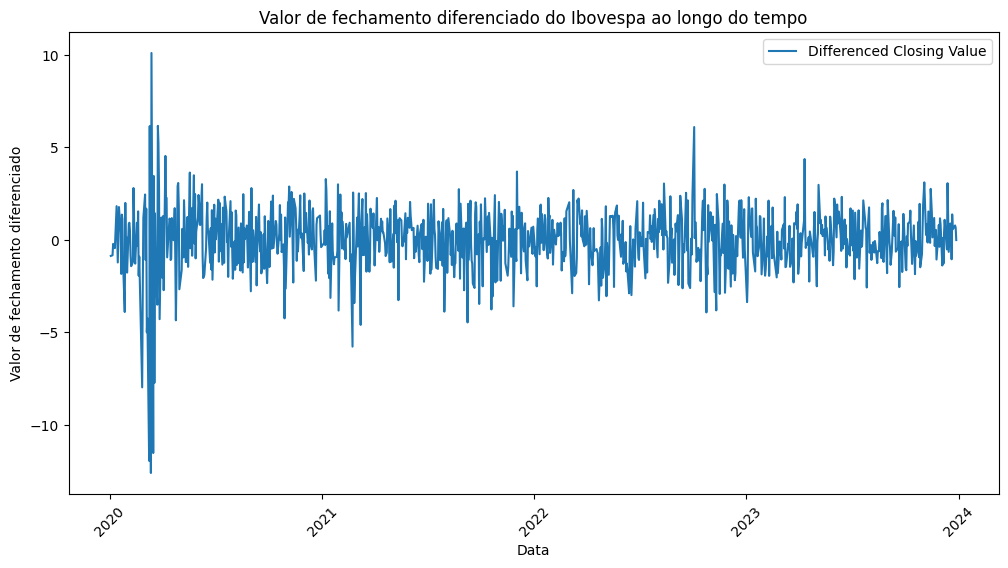

1.7482880628989594e-18

In [93]:
# Diferenciação

ibovespa_diff = df['Último'].diff().dropna()

adf_test_diff = adfuller(ibovespa_diff)

adf_p_value_diff = adf_test_diff[1]

plt.figure(figsize=(12,6))
plt.plot(ibovespa_diff, label='Differenced Closing Value')
plt.title('Valor de fechamento diferenciado do Ibovespa ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento diferenciado')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.legend()
plt.show()

adf_p_value_diff

Para tornar a série estacionária, a diferenciação é aplicada. A diferenciação remove tendências e sazonalidades da série.
A série diferenciada é visualizada para verificar se as tendências e sazonalidades foram removidas.
Com base no gráfico apresentado, parece que o modelo ARIMA foi eficaz em remover as tendências e sazonalidades do valor de fechamento do Ibovespa.


<Figure size 1200x400 with 0 Axes>

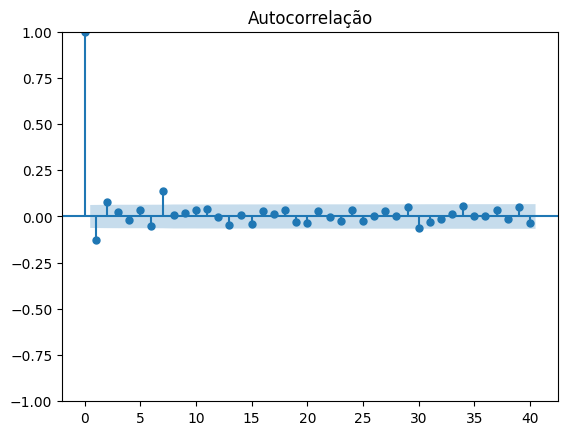

<Figure size 1200x400 with 0 Axes>

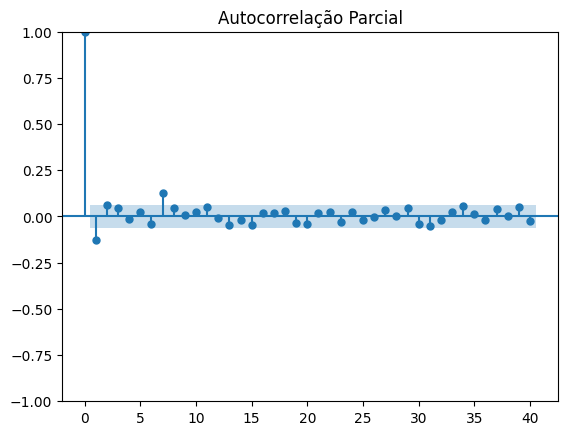

In [97]:
#  Análise de Correlação

plt.figure(figsize=(12, 4))
plot_acf(ibovespa_diff, lags=40)
plt.title('Autocorrelação')
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(ibovespa_diff, lags=40)
plt.title('Autocorrelação Parcial')
plt.show()

As funções de autocorrelação (ACF) e autocorrelação parcial (PACF) são usadas para identificar a ordem do modelo ARIMA (ordem de \(p\) e \(q\)).
Autocorrelação Inicial Forte: O valor da autocorrelação na defasagem 0 é sempre 1, indicando que um valor é perfeitamente correlacionado consigo mesmo. No entanto, o que mais chama a atenção é a autocorrelação significativa na primeira defasagem (lag 1).  Após a primeira defasagem, a autocorrelação decai rapidamente para valores próximos de zero. Isso indica que a influência de valores mais distantes no passado sobre o valor atual é bastante limitada.
O gráfico de Autocorrelação Parcial (PACF) apresentado indica uma forte autocorrelação na primeira defasagem (lag 1) e autocorrelações não significativas para as demais defasagens. Isso sugere que o valor de uma observação está significativamente relacionado ao valor da observação imediatamente anterior, mas não a valores mais distantes no passado.


In [100]:
train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]
train_arima = train_data['Último']
test_arima = test_data['Último']

train_history = [x for x in train_arima]
y = test_arima

predictions = list()
model = ARIMA(train_history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
print(yhat)
predictions.append(yhat)
train_history.append(y.iloc[0])

120.62247909681741


O resultado impresso 120.62247909681741 representa a previsão do modelo para o primeiro valor do conjunto de teste.

In [101]:
for i in range(1, len(y)):

    model = ARIMA(train_history, order=(1,1,0))
    model_fit = model.fit()

    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    obs = y.iloc[i]

    train_history.append(obs)

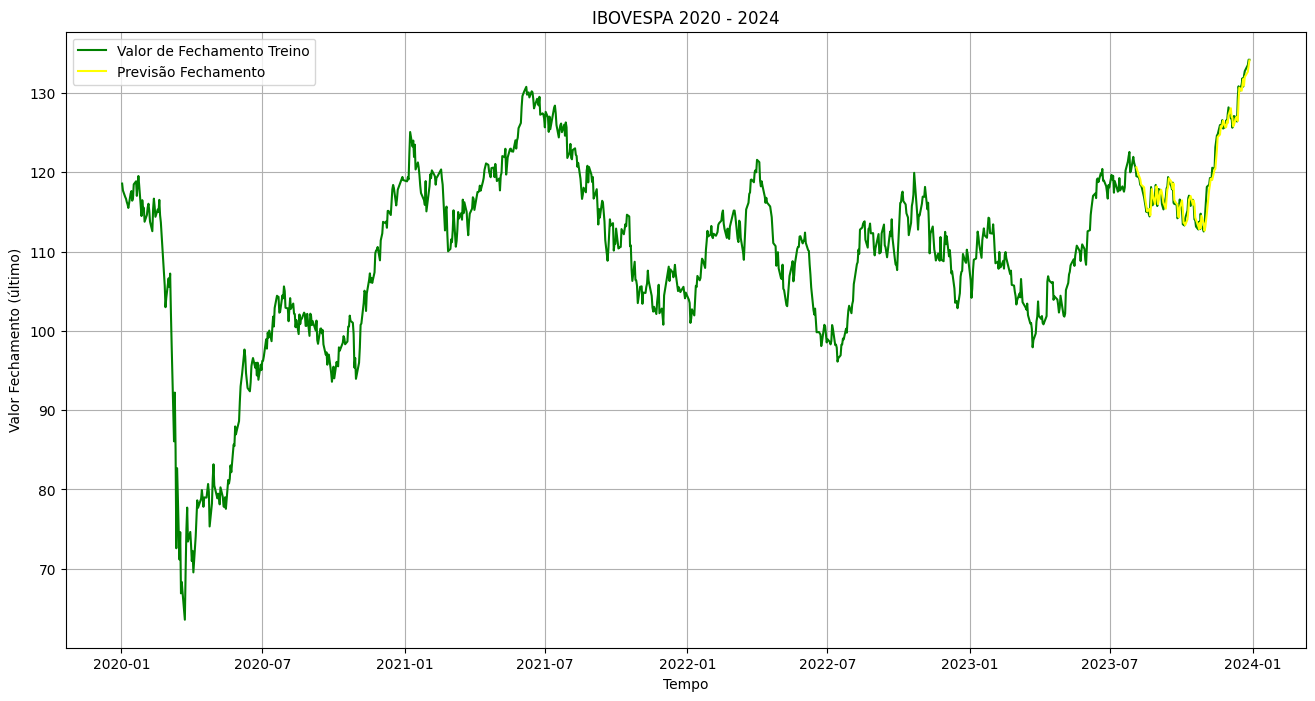

In [102]:
plt.figure(figsize=(16,8))
plt.plot(df.index, df['Último'], color='green', label = 'Valor de Fechamento Treino')
plt.plot(test_data.index, predictions, color = 'yellow', label = 'Previsão Fechamento')
plt.title('IBOVESPA 2020 - 2024')
plt.xlabel('Tempo')
plt.ylabel('Valor Fechamento (último)')
plt.legend()
plt.grid(True)
plt.show()

Observando o gráfico podemos considerar que linha da previsão de fechamento acompanha de forma relativamente próxima a linha do fechamento real, sugerindo que o modelo utilizado para gerar as previsões apresenta um bom ajuste aos dados históricos.
Podemos visualizar uma a alta volatilidade, os valores do índice oscilam consideravelmente ao longo do período, refletindo a reação do mercado a diversos fatores, como notícias econômicas, políticas, eventos geopolíticos e incertezas do mercado.
A tendência geral do período analisado é de alta, com o índice atingindo níveis cada vez mais elevados. Essa tendência positiva pode ser atribuída a diversos fatores, como a recuperação econômica após a pandemia da COVID-19, o otimismo dos investidores com o futuro da economia brasileira e o aumento dos lucros das empresas listadas na bolsa.


In [ ]:
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))


MSE: 1.3314492905844575
MAE: 0.9370323720360298
RMSE: 1.153884435541297


MSE = 1.3314: Indica que, em média, o quadrado da diferença entre os valores reais e previstos é de aproximadamente 1.33.
MAE = 0.9370: Indica que, em média, o valor absoluto da diferença entre os valores reais e previstos é de aproximadamente 0.94.
RMSE = 1.1539: Indica que, em média, a diferença entre os valores reais e previstos é de aproximadamente 1.15.
Comparando MSE e MAE, o MSE é maior que o MAE, o que sugere a presença de alguns outliers que estão influenciando significativamente o MSE. O MAE, por ser menos sensível a outliers, apresenta um valor menor.
O RMSE, o modelo está errando em aproximadamente 1.15 unidades da variável alvo. Os resultados indicam que o modelo de regressão apresenta um erro médio relativamente baixo.


# Conclusão

O período utilizado para treinar o modelo foram os dados a partir de 2020, pois nesse período a quantidade de ruído externo era menor do que comparado com os anos anteriores, onde tivemos a crise em 2008, a crise política em 2016 e a pandemia no final de 2019.
Além disso, as métricas de avaliação de erro escolhidas foram o MSE (Erro Quadrático Médio), o MAE (Erro Absoluto Médio) e o RMSE (Erro Quadrático Médio da Raiz), por fornecerem uma medida mais sensível às diferenças absolutas entre as previsões e os valores reais.
Sendo assim, ao comparar os modelos LSTM, CNN e ARIMA, o modelo que apresentou o melhor gráfico de predição e o menor erro foi o ARIMA, tendo MSE de 1.34, MAE de 0.93 e RMSE de 1.15. Enquanto o modelo LSTM apresentou MSE de 11.20 e MAE de 2.11 e RMSE de 3.34. E o modelo CNN obteve os resultados Train MSE de 7.10 e Test MSE de 9.68.